## Boiler Plate

In [158]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing libaries

In [159]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [161]:
path = Path('../data/caltech101/')

## Loading Data and Model

In [165]:
??ImageItemList.split_by_idx()

In [167]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageItemList.from_folder(path)
        .no_split()
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64))

In [168]:
learn = create_cnn(data, models.resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\100967/.torch\models\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████| 87306240/87306240 [00:21<00:00, 3999601.03it/s]


## Extracting Feature

Creating a hook right after convolutional part of resnet 50 and max pooling layer which generates a 4096 length vector for a particular image of 256*256.

In [170]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][1])

Creating Feature Vector

In [171]:
_ = learn.get_preds(ds_type=DatasetType.Train)
_ = learn.get_preds(ds_type=DatasetType.Valid)

AttributeError: 'NoneType' object has no attribute 'update'

Converting in a dictionary of path:featurevector

In [26]:
feature_dict = dict(zip(list(data.train_ds.items)+list(data.valid_ds.items),sf.features))

In [36]:
## Exporting as pickle
pickle.dump(feature_dict, open(path/"feature_dict.p", "wb"))

## Importing it again

In [4]:
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))

In [5]:
feature_dict[list(feature_dict.keys())[0]]

array([2.566588, 2.242792, 3.930533, 2.010188, ..., 0.184121, 0.285987, 0.307261, 0.368305], dtype=float32)

In [6]:
from lshash.lshash import LSHash

In [7]:
# params
k = 10 # hash size
L = 5  # number of tables
d = 4096

lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

In [9]:
from tqdm import tqdm_notebook

In [10]:
# indexing
for path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec, extra_data=path)

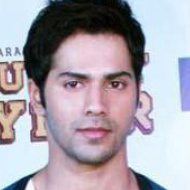

In [37]:
open_image('../data/celeba/faces/./validation/182643.jpg')

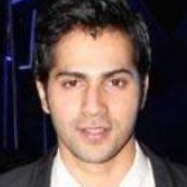

In [90]:
open_image('../data/celeba/faces/./validation/182644.jpg')

In [104]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity

In [93]:
1 - spatial.distance.cosine(
    feature_dict['../data/celeba/faces/./validation/182643.jpg'], 
    feature_dict['../data/celeba/faces/./validation/182644.jpg']
)

0.9018394947052002

In [138]:
1 - spatial.distance.cosine(
    feature_dict['../data/celeba/faces/./validation/182643.jpg'], 
    feature_dict[response[19][0][1]]
)

0.9546335339546204

In [91]:
feature_dict['../data/celeba/faces/./validation/182644.jpg']

array([2.592371, 3.019694, 2.516221, 2.251394, ..., 0.611072, 0.207924, 0.426275, 0.238096], dtype=float32)

In [139]:
# query a vector q_vec
response = lsh.query(feature_dict['../data/celeba/faces/./validation/182643.jpg'], 
                     num_results=20, distance_func='cosine')

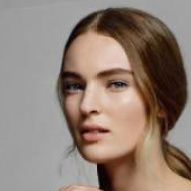

In [157]:
open_image(response[1][0][1])

'../data/celeba/faces/./validation/184389.jpg'